# Scattering Matrix Plugin

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FSMatrix.ipynb).

This notebook will give a demo of the tidy3d [ComponentModeler](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.ComponentModeler.html) plugin used to compute scattering matrix elements.

In [1]:
# make sure notebook plots inline
%matplotlib inline

# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm
import gdspy

# tidy3D imports
import tidy3d as td
from tidy3d import web

# set tidy3d to only print error information to reduce verbosity
td.set_logging_level('error')

Using Tidy3D credentials from stored file


## Setup

We will simulate a directional coupler, similar to the GDS and Parameter scan tutorials.

Let's start by setting up some basic parameters.

In [2]:
# wavelength / frequency
lambda0 = 1.550                     # all length scales in microns
freq0 = td.constants.C_0 / lambda0
fwidth = freq0 / 10

# Permittivity of waveguide and substrate
wg_n = 3.48
sub_n = 1.45
mat_wg = td.Medium(permittivity=wg_n**2)
mat_sub = td.Medium(permittivity=sub_n**2)

# Waveguide dimensions

# Waveguide height
wg_height = 0.22
# Waveguide width
wg_width = 1.0#0.45
# Waveguide separation in the beginning/end
wg_spacing_in = 8
# length of coupling region (um)
coup_length = 6.0
# spacing between waveguides in coupling region (um)
wg_spacing_coup = 0.05
# Total device length along propagation direction
device_length = 100
# Length of the bend region
bend_length = 16
# Straight waveguide sections on each side
straight_wg_length = 4
# space between waveguide and PML
pml_spacing = 2
# Mesh step in all directions
dl = 50e-3   

### Define waveguide bends and coupler

Here is where we define our directional coupler shape programmatically in terms of the geometric parameters

In [3]:
def bend_pts(bend_length, width, npts=10):
    """ Set of points describing a tanh bend from (0, 0) to (length, width)"""
    x = np.linspace(0, bend_length, npts)
    y = width*(1 + np.tanh(6*(x/bend_length - 0.5)))/2
    return np.stack((x, y), axis=1)

def arm_pts(length, width, coup_length, bend_length, npts_bend=30):
    """ Set of points defining one arm of an integrated coupler """
    ### Make the right half of the coupler arm first
    # Make bend and offset by coup_length/2
    bend = bend_pts(bend_length, width, npts_bend)
    bend[:, 0] += coup_length / 2
    # Add starting point as (0, 0)
    right_half = np.concatenate(([[0, 0]], bend))
    # Add an extra point to make sure waveguide is straight past the bend
    right_half = np.concatenate((right_half, [[right_half[-1, 0] + 0.1, width]]))
    # Add end point as (length/2, width)
    right_half = np.concatenate((right_half, [[length/2, width]]))

    # Make the left half by reflecting and omitting the (0, 0) point
    left_half = np.copy(right_half)[1:, :]
    left_half[:, 0] = -left_half[::-1, 0]
    left_half[:, 1] = left_half[::-1, 1]
    
    return np.concatenate((left_half, right_half), axis=0)

def make_coupler(
    length, 
    wg_spacing_in,
    wg_width,
    wg_spacing_coup,
    coup_length,
    bend_length,
    npts_bend=30):
    """ Make an integrated coupler using the gdspy FlexPath object. """

    # Compute one arm of the coupler
    arm_width = (wg_spacing_in - wg_width - wg_spacing_coup)/2
    arm = arm_pts(length, arm_width, coup_length, bend_length, npts_bend)
    # Reflect and offset bottom arm
    coup_bot = np.copy(arm)
    coup_bot[:, 1] = -coup_bot[::-1, 1] - wg_width/2 - wg_spacing_coup/2
    # Offset top arm
    coup_top = np.copy(arm)
    coup_top[:, 1] += wg_width/2 + wg_spacing_coup/2
    
    # Create waveguides as GDS paths
    path_bot = gdspy.FlexPath(coup_bot, wg_width, layer=1, datatype=0)
    path_top = gdspy.FlexPath(coup_top, wg_width, layer=1, datatype=1)
    
    return [path_bot, path_top]

### Create Base Simulation

The scattering matrix tool requires the "base" [Simulation](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.Simulation.html) (without the modal sources or monitors used to compute S-parameters), so we will construct that now.

We generate the structures and add a [FieldMonitor](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldMonitor.html?highlight=FieldMonitor) so we can inspect the field patterns.

In [4]:
gdspy.current_library = gdspy.GdsLibrary()
lib = gdspy.GdsLibrary()

# Geometry must be placed in GDS cells to import into Tidy3D
coup_cell = lib.new_cell('Coupler')

substrate = gdspy.Rectangle(
    (-device_length/2, -wg_spacing_in/2-10),
    (device_length/2, wg_spacing_in/2+10),
    layer=0)
coup_cell.add(substrate)

# Add the coupler to a gdspy cell
gds_coup = make_coupler(
    device_length,
    wg_spacing_in,
    wg_width,
    wg_spacing_coup,
    coup_length,
    bend_length)
coup_cell.add(gds_coup)

# Substrate
[oxide_geo] = td.PolySlab.from_gds(
    gds_cell=coup_cell,
    gds_layer=0,
    gds_dtype=0,
    slab_bounds=(-10, 0),
    axis=2)

oxide = td.Structure(
    geometry=oxide_geo,
    medium=mat_sub)

# Waveguides (import all datatypes if gds_dtype not specified)
coupler1_geo, coupler2_geo = td.PolySlab.from_gds(
    gds_cell=coup_cell,
    gds_layer=1,
    slab_bounds=(0, wg_height),
    axis=2)

coupler1 = td.Structure(
    geometry=coupler1_geo,
    medium=mat_wg
)

coupler2 = td.Structure(
    geometry=coupler2_geo,
    medium=mat_wg
)

# Simulation size along propagation direction
sim_length = 2*straight_wg_length + 2*bend_length + coup_length

# Spacing between waveguides and PML
sim_size = [
    sim_length,
    wg_spacing_in + wg_width + 2*pml_spacing,
    wg_height + 2*pml_spacing]

# source
src_pos = sim_length/2 - straight_wg_length/2

domain_monitor = td.FieldMonitor(
    center = [0,0,wg_height/2],
    size = [td.inf, td.inf, 0],
    freqs = [freq0],
    name='field'
)

# initialize the simulation
sim = td.Simulation(
    size=sim_size,
    grid_size=(dl, dl, dl),
    structures=[oxide, coupler1, coupler2],
    sources=[],
    monitors=[domain_monitor],
    run_time=20/fwidth,
    pml_layers=3*[td.PML()])


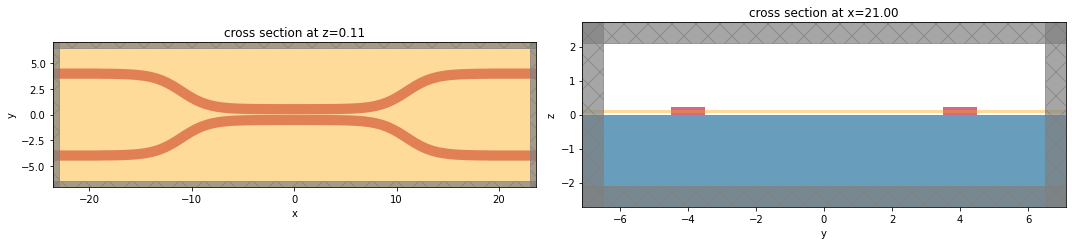

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 10))
ax1 = sim.plot(z=wg_height/2, ax=ax1)
ax2 = sim.plot(x=src_pos, ax=ax2)

## Setting up Scattering Matrix Tool
Now, to use the S matrix tool, we need to defing the spatial extent of the "ports" of our system using [Port](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.Port.html) objects.

These ports will be converted into modal sources and monitors later, so they require both some mode specification and a definition of the direction that points into the system.

We'll also give them names to refer to later.

In [6]:
from tidy3d.plugins.smatrix.smatrix import Port

# number of mode orders to include for each port in the S marix calculation
num_modes = 2

port_right_top = Port(
    center=[src_pos, wg_spacing_in / 2, wg_height / 2],
    size=[0, 4, 2],
    mode_spec=td.ModeSpec(num_modes=num_modes),
    direction='-',
    name='right_top')

port_right_bot = Port(
    center=[src_pos, -wg_spacing_in / 2, wg_height / 2],
    size=[0, 4, 2],
    mode_spec=td.ModeSpec(num_modes=num_modes),
    direction='-',
    name='right_bot')

port_left_top = Port(
    center=[-src_pos, wg_spacing_in / 2, wg_height / 2],
    size=[0, 4, 2],
    mode_spec=td.ModeSpec(num_modes=num_modes),
    direction='+',
    name='left_top')

port_left_bot = Port(
    center=[-src_pos, -wg_spacing_in / 2, wg_height / 2],
    size=[0, 4, 2],
    mode_spec=td.ModeSpec(num_modes=num_modes),
    direction='+',
    name='left_bot')

ports = [port_right_top, port_right_bot, port_left_top, port_left_bot]

Next, we will add the base simulation and ports to the [ComponentModeler](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.ComponentModeler.html), along with the frequency of interest and a name for saving the batch of simulations that will get created later.

In [7]:
from tidy3d.plugins.smatrix.smatrix import ComponentModeler
modeler = ComponentModeler(simulation=sim, ports=ports, freq=freq0, batch_path='data/smatrix_batch.json')

We can plot the simulation with all of the ports as sources to check things are set up correctly.

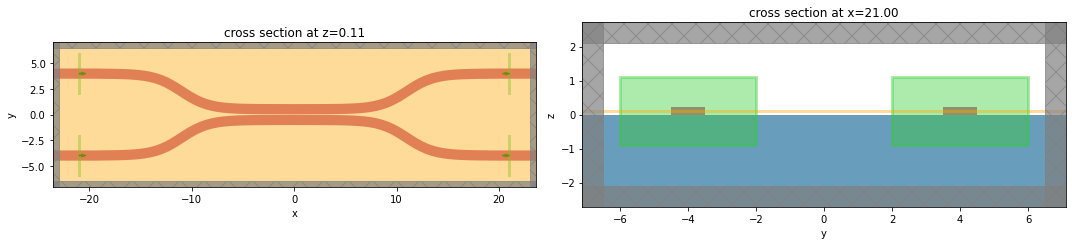

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(15, 10))
ax1 = modeler.plot_sim(z=wg_height/2, ax=ax1)
ax2 = modeler.plot_sim(x=src_pos, ax=ax2)

## Solving for the S matrix

With the component modeler defined, we may call it's `.solve()` method to run a batch of simulations to compute the S matrix.
The tool will loop through each port and create one simulation per mode index (as defined by the mode specifications) where a unique modal source is injected.
Each of the ports will also be converted to mode monitors to measure the mode amplitudes and normalization.

In [9]:
smatrix = modeler.solve(path_dir='data')

[13:57:23] Started working on Batch.                                         ]8;id=141389;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=833635;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#356\356]8;;\

Output()

smatrix_portright_top_mode0: status = success ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
smatrix_portright_top_mode1: status = success ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
smatrix_portright_bot_mode0: status = success ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
smatrix_portright_bot_mode1: status = success ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
smatrix_portleft_top_mode0: status = success  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
smatrix_portleft_top_mode1: status = success  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
smatrix_portleft_bot_mode0: status = success  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00
smatrix_portleft_bot_mode1: status = success  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

[14:01:04] Batch complete.                                                   ]8;id=114932;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=948122;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#377\377]8;;\

Output()

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

Output()

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

Output()

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

Output()

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

Output()

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

Output()

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

Output()

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

Output()

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

In [10]:
# or, if already saved to files, can load the same smatrix without running sims again
batch_data = modeler.load()

## Working with Scattering Matrix

The scattering matrix returned by the solve is actually a nested dictionarty relating the port names.
For example `smatrix[name1][name2]` gives an array of shape `(m, n)` relating the coupling between the `m` modes injected into port `name1` with the `n` modes measured in port `name2`.

For example, here each waveguide has 2 modes, so we can compute the coupling between the 2 input modes in `left_top` with the 2 output modes in `right_bot` as:

In [11]:
smatrix['left_top']#['right_bot']

{
    'right_top': array([[-0.91638695-0.38671303j, -0.00130938+0.03038015j],
       [-0.00861398+0.02909003j, -0.71894914-0.50593971j]]),
    'right_bot': array([[ 0.02692388-0.06570962j, -0.00383968+0.02783249j],
       [ 0.01097735-0.02993188j, -0.24184259+0.35089474j]]),
    'left_top': array([[0.00040553-4.13273693e-05j, 0.00876376+9.44405305e-03j],
       [0.00716822+1.06211583e-02j, 0.02554891+1.22332851e-02j]]),
    'left_bot': array([[-0.00069014-0.00055105j,  0.00263632+0.00193133j],
       [-0.00203512-0.00258381j,  0.00346431+0.010972j  ]])
}

Alternatively, we can convert this into a numpy array:

In [12]:
blocks_cols = []
for port_name_in, val_in in smatrix.items():
    blocks_rows = []
    for port_name_out, S_in_out in val_in.items():
        blocks_rows.append(S_in_out)
    blocks_cols.append(np.block(blocks_rows))
S = np.concatenate(blocks_cols)
print(S.shape)

(8, 8)


We can inspect `S` and note that the diagonal elements are very small indicating low backscattering.

In [13]:
print(abs(S)**2)

[[2.26951372e-07 1.46872673e-04 7.76053072e-07 1.05713691e-05
  9.89343664e-01 9.34533078e-04 5.04434026e-03 7.86498792e-04]
 [1.45431437e-04 7.17453924e-04 1.07283700e-05 1.32186709e-04
  9.10411241e-04 7.73091223e-01 1.02733705e-03 1.81624525e-01]
 [7.76953512e-07 1.07666074e-05 5.50024752e-07 1.47780898e-04
  5.04262832e-03 1.01736857e-03 9.88776550e-01 1.40593029e-03]
 [1.05487366e-05 1.32223204e-04 1.49506646e-04 8.76630787e-04
  7.87451349e-04 1.81710262e-01 1.37430651e-03 7.60288488e-01]
 [9.89312019e-01 9.24668144e-04 5.04264960e-03 7.89390523e-04
  1.66159657e-07 1.65993678e-04 7.79945064e-07 1.06802124e-05]
 [9.20430638e-04 7.72862855e-01 1.01641965e-03 1.81614952e-01
  1.64192444e-04 8.02400030e-04 1.08177720e-05 1.32386249e-04]
 [5.04336801e-03 1.02773978e-03 9.88724175e-01 1.39536276e-03
  7.80736808e-07 1.08572167e-05 5.22392339e-07 1.52910635e-04]
 [7.84808796e-04 1.81679222e-01 1.38459360e-03 7.60354784e-01
  1.06608835e-05 1.32470475e-04 1.51814508e-04 9.24811746e-04]]

Summing each rows of the matrix should give 1.0 if no power was lost.

In [14]:
np.sum(abs(S)**2, axis=0)

array([0.99621761, 0.9575018 , 0.9963294 , 0.94532166, 0.99625995,
       0.95786511, 0.99638647, 0.94532623])

Finally, we can check whether `S` is close to unitary as expected.

S times it's Hermitian conjugate should be the identy matrix.

In [15]:
mat = S @ (np.conj(S.T))

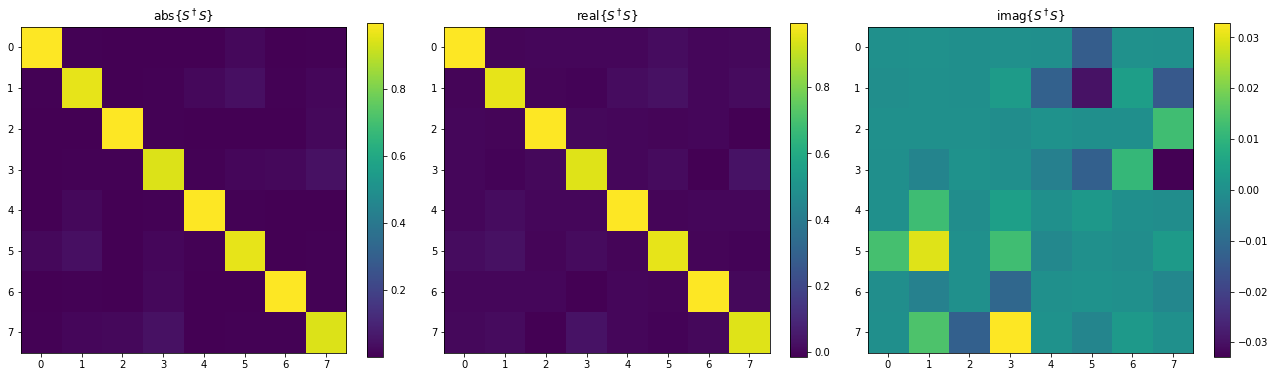

In [16]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(18, 5))
imabs = ax1.imshow(abs(mat))
imreal = ax2.imshow(mat.real)
imimag = ax3.imshow(mat.imag)
plt.colorbar(imabs, ax=ax1)
plt.colorbar(imreal, ax=ax2)
plt.colorbar(imimag, ax=ax3)
ax1.set_title('abs{$S^\dagger S$}')
ax2.set_title('real{$S^\dagger S$}')
ax3.set_title('imag{$S^\dagger S$}')
plt.show()

It looks pretty close, but there seems to indeed be a bit of loss (expected).

## Viewing individual Simulation Data
To verify, we may want to take a look the individual simulation data.
For that, we can load up the batch and inspect the [SimulationData](https://docs.simulation.cloud/projects/tidy3d/en/latest/_autosummary/tidy3d.Simulation.html) for each task.

In [17]:
batch_data = modeler.batch_data

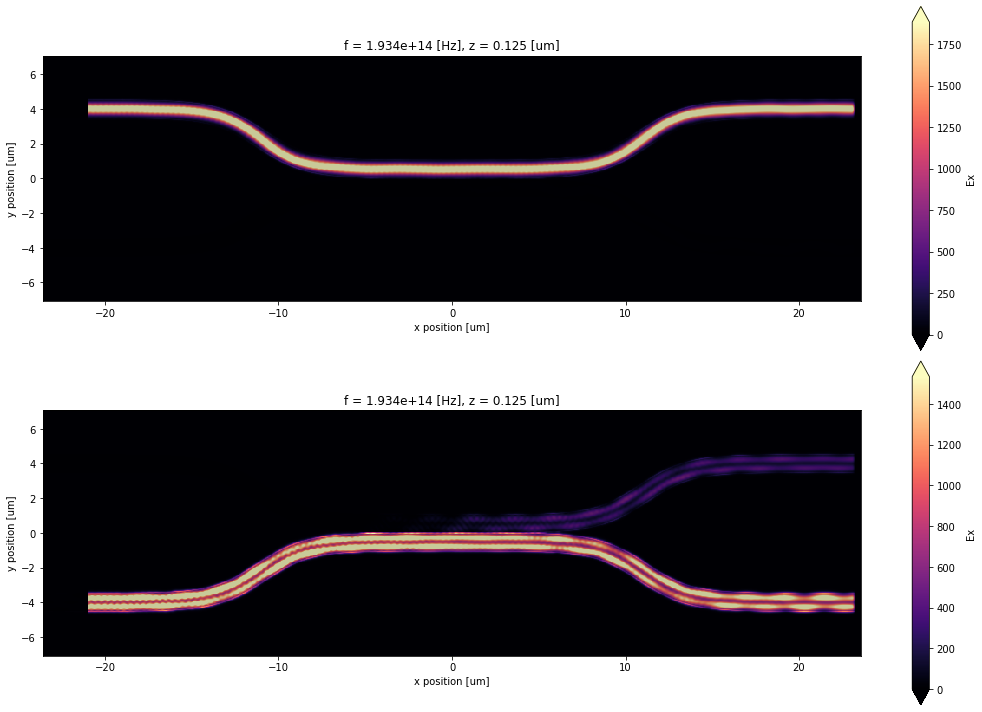

In [19]:
f, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, figsize=(15, 10))
ax1 = batch_data['smatrix_portleft_top_mode0'].plot_field('field', 'int', freq=freq0, z=wg_height/2, ax=ax1)
ax2 = batch_data['smatrix_portleft_bot_mode1'].plot_field('field', 'int', freq=freq0, z=wg_height/2, ax=ax2)